In [8]:
# Results from all Olympic Track & Field Events, 1896 - 2016
# https://www.kaggle.com/datasets/jayrav13/olympic-track-field-results?resource=download
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

In [203]:
invert = set([
    'Decathlon Men',
    'Discus Throw Men',
    'Hammer Throw Men',
    'High Jump Men',
    'Javelin Throw Men',
    'Long Jump Men',
    'Pole Vault Men',
    'Shot Put Men',
    'Triple Jump Men',
    'Discus Throw Women',
    'Hammer Throw Women',
    'Heptathlon Women',
    'High Jump Women',
    'Javelin Throw Women',
    'Long Jump Women',
    'Pole Vault Women',
    'Shot Put Women',
    'Triple Jump Women',
])

data = defaultdict(Counter)

def parse_time(result, name):
    if ':' not in result:
        return float(result)
    hours = 0
    if result.endswith(' est'):  # '3:23.0 est'
        result = result[:-4]
    if '-' in result or 'h' in result:  # '3-06:03'
        result = result.replace('-', ':').replace('h', ':')
    if name == 'Marathon Men' and result.count(':') == 1:  # M,Marathon Men,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32.57
            result = result.replace('.', ':')
    result = result.split(':')
    time = 0
    for i in result:
        time *= 60
        time += float(i)
    return time

with open('../sport_records/archive/results.csv') as f:
    for line in f.readlines()[1:]:
        line = line.strip()
        line = line.split(',')
        name = line[1]
        year = int(line[3])
        result = line[-2] if line[-1].startswith('-') or line[-1].startswith('+') else line[-1]  # W,100M Hurdles Women,Beijing,2008,G,Dawn HARPER,USA,12.54,+0.1
        if result == 'None' or result.endswith(' P.'):  # '8053.29  P.'
            continue
        try:
            result = parse_time(result, name)
            if data[name][year] == 0 or ((data[name][year] > result) ^ (name in invert)):
                data[name][year] = result
        except:
            print(line)

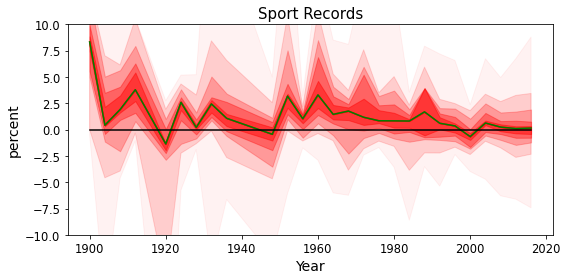

In [208]:
def rel(name, a, b, threshold=1_000_000):
    val = (b-a)/a*100
    if abs(val) > threshold:
        val = 0
    if name not in invert:
        val *= -1
    return val

def avg(vals):
    return sum(vals) / len(vals)

total_years = set()
data_rel = defaultdict(Counter)
data_rel0 = defaultdict(Counter)
def fill_data(data, total_years, data_rel):
    for i in data:
        if len(data[i]) < 5:
            continue
        years = list(sorted(data[i].keys()))
        xs = [rel(i, data[i][a], data[i][b]) for a, b in zip(years[:-1], years[1:])]  # [100] + 
        xs0 = [rel(i, data[i][years[0]], data[i][b]) for a, b in zip(years[:-1], years[1:])]
        data_rel0[years[0]][i] = 0
        for year, (x, x0) in zip(years[1:], zip(xs,  xs0)):
            data_rel[year][i] = x
            data_rel0[year][i] = x0
            total_years.add(year)    

fill_data(data, total_years, data_rel)

indx_to_year = {indx:year for indx, year in enumerate(sorted(total_years))}
SDist=np.zeros((len(total_years),11))
for i in range(11):
     for t in range(len(total_years)):
         SDist[t,i]=np.percentile(list(data_rel[indx_to_year[t]].values()),i*10)

x = list(sorted(total_years))
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,4))
ax1.set_prop_cycle(color=['red'])
ax1.plot(x, SDist[:,5])
for i in range(6):
    alph=0.05+(i/10.)
    ax1.fill_between(x, SDist[:,0+i], SDist[:,10-i], color="red", alpha=alph)
ax1.set_title("Sport Records", fontsize=15)
ax1.tick_params(labelsize=11.5)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('percent', fontsize=14)
plt.ylim(ymax = 10, ymin = -10)
ax1.plot(x, [np.median(list(data_rel[y].values())) for y in x], color='green')
ax1.plot(x, np.zeros(len(x)), color='black')
fig.tight_layout()

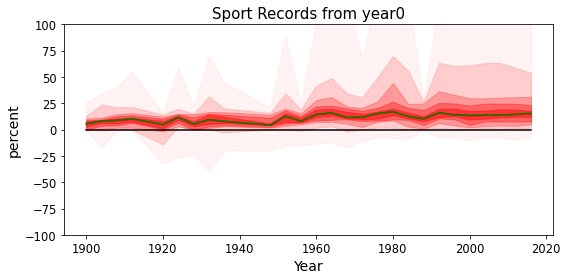

In [209]:
indx_to_year = {indx:year for indx, year in enumerate(sorted(total_years))}
SDist=np.zeros((len(total_years),11))
for i in range(11):
     for t in range(len(total_years)):
         SDist[t,i]=np.percentile(list(data_rel0[indx_to_year[t]].values()),i*10)

x = list(sorted(total_years))
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,4))
ax1.set_prop_cycle(color=['red'])
ax1.plot(x, SDist[:,5])
for i in range(6):
    alph=0.05+(i/10.)
    ax1.fill_between(x, SDist[:,0+i], SDist[:,10-i], color="red", alpha=alph)
ax1.set_title("Sport Records from year0", fontsize=15)
ax1.tick_params(labelsize=11.5)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('percent', fontsize=14)
plt.ylim(ymax = 100, ymin = -100)
ax1.plot(x, [np.median(list(data_rel0[y].values())) for y in x], color='green')
ax1.plot(x, np.zeros(len(x)), color='black')
fig.tight_layout()